In [1]:
import re
import tensorflow as tf
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook

from nltk.corpus import stopwords

In [2]:
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

Using TensorFlow backend.


In [3]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [4]:
train = pd.read_csv('data/train.csv')

In [5]:
train.shape

(159571, 8)

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [8]:
y = train[labels].values

In [9]:
y.shape

(159571, 6)

In [10]:
comments_train = train['comment_text']
comments_train = list(comments_train)

In [11]:
len(comments_train)

159571

In [12]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")

In [13]:
texts = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    texts.append(clean_text(line))

/Users/mohammadtanweer/Documents/software/anaconda3/envs/revolut/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
print('Sample data:', texts[1], y[1])

Sample data: aww matches background colour im seemingly stuck thanks talk 2151 january 11 2016  [0 0 0 0 0 0]


In [15]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 324669


In [16]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)


In [17]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [18]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12115  1258  6696   382  6248  1141]
validation:  [3179  337 1753   96 1629  264]


In [19]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [  376    55     2   255  1857 16196     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

In [50]:

embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [51]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

In [52]:
# model = Model(sequence_input, preds)
model.compile(loss = 'categorical_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

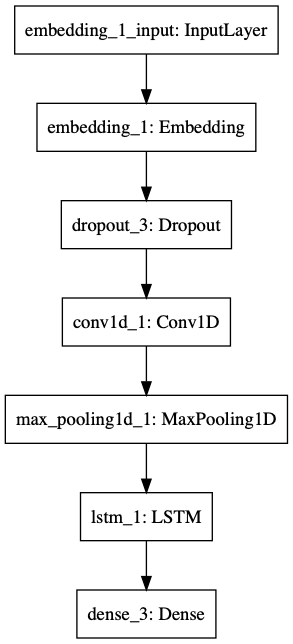

In [53]:
tf.keras.utils.plot_model(model)

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          32467000  
_________________________________________________________________
dropout_3 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 64)           32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 32,532,478
Trainable params: 65,478
Non-trainable params: 32,467,000
_____________________________________

In [55]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 5, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Epoch 1/5
3990/3990 [==============================] - 138s 35ms/step - loss: 0.3366 - accuracy: 0.9856 - val_loss: 0.3416 - val_accuracy: 0.9900
Epoch 2/5
3990/3990 [==============================] - 120s 30ms/step - loss: 0.3284 - accuracy: 0.9847 - val_loss: 0.3373 - val_accuracy: 0.9871
Epoch 3/5
3990/3990 [==============================] - 134s 34ms/step - loss: 0.3258 - accuracy: 0.9826 - val_loss: 0.3350 - val_accuracy: 0.8458
Epoch 4/5
3990/3990 [==============================] - 125s 31ms/step - loss: 0.3255 - accuracy: 0.9876 - val_loss: 0.3382 - val_accuracy: 0.9933
Epoch 5/5
3990/3990 [==============================] - 121s 30ms/step - loss: 0.3255 - accuracy: 0.9913 - val_loss: 0.3362 - val_accuracy: 0.9936


In [47]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

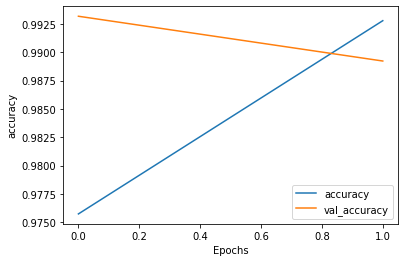

In [48]:
plot_graphs(history, 'accuracy')

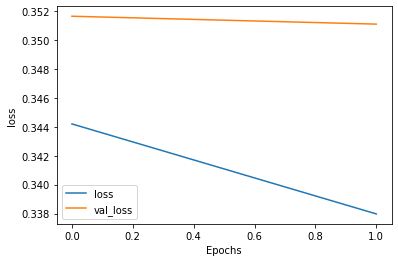

In [49]:
plot_graphs(history, 'loss')

In [ ]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Conv1D(64, 5, activation='relu'),
#     tf.keras.layers.MaxPooling1D(pool_size=4),
#     tf.keras.layers.LSTM(64),
#     tf.keras.layers.Dense(6, activation='sigmoid')
# ])

In [ ]:
model.compile(loss = 'categorical_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.summary()

In [ ]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 5, batch_size=32, validation_data=(x_val, y_val))

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')